## Script Engine Performance Test

Two JS engines were compared: Rhino and Nashorn. These tests were used: [dromaeo](http://dromaeo.com/?dromaeo) 

Before measure perofrmance 20 warm up iterations were executed to allow JIT make some optimizations. 

**System Configuration**:

OS: Microsoft Windows 10 Pro 10.0.16299 Build 16299	<br>

Processor: Intel(R) Core(TM) i3-4130 CPU @ 3.40GHz, 3400 Mhz, 2 Core(s), 4 Logical Processor(s)<br>

RAM: 16 GB

Java:<br>

`java version "1.8.0_161"
Java(TM) SE Runtime Environment (build 1.8.0_161-b12)
Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)`

In [1]:
#input params

warmup_count = 20
warmup_graph_columns = 2

In [4]:
import json
import numpy as np

data = {}
def load_test_res(path):
    #print('loading from: '+path)
    res = []
    tests = json.load(open(path))
    
    for i,test in enumerate(tests):
        local = {}
        local['name'] = test['name']
        local['samples'] = 1/np.array(test['stats']['sample'])
        local['speed_error'] = test['speed']*test['stats']['rme']/100
        local['speed'] = test['speed']
        res.append(local)
    return res
    
def load_test_results(engine):
    res = []
    res.append(load_test_res('results/'+engine+'/results.out'))
    for i in range(0, warmup_count):
        res.append(load_test_res('warmup/'+engine+'/results-iter'+str(i)+'.out'));
    data[engine] = res

In [5]:
load_test_results('nashorn')
load_test_results('rhino')
#nill

In [6]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def prepare_warmup_test(testNo):
    res = {
        'name': data['nashorn'][1][testNo]['name'],
        'nashorn': {},
        'rhino': {}
    }
    res['nashorn']['speed'] = \
        [iteration[testNo]['speed'] for i, iteration in enumerate(data['nashorn']) if i > 0]
    res['nashorn']['speed_error'] = \
        [iteration[testNo]['speed_error'] for i, iteration in enumerate(data['nashorn']) if i > 0]
    res['rhino']['speed'] = \
        [iteration[testNo]['speed'] for i, iteration in enumerate(data['rhino']) if i > 0]
    res['rhino']['speed_error'] = \
        [iteration[testNo]['speed_error'] for i, iteration in enumerate(data['rhino']) if i > 0]
    return res
    
def warmup_tests_count():
    return len(data['nashorn'][1])

def draw_warmup_tests():
    ncols = warmup_graph_columns
    nrows = math.ceil(warmup_tests_count()/ncols)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,50))
    plt.subplots_adjust(bottom=0.1, right=0.8)
    plt.suptitle('Warm Up iterations', fontsize=16, y = 0.9)
    
    for row in range(0, nrows):
        for col in range(0, ncols):
            
            #plt.subplot(nrows, ncols, i+1)
            graph_data = prepare_warmup_test(row * ncols + col)
            x = np.arange(warmup_count)
            axes[row, col].errorbar(x, graph_data['nashorn']['speed'], 
                                    graph_data['nashorn']['speed_error'], capsize=5, 
                                    elinewidth=2, markeredgewidth=2,
                                    label='nashorn', marker='.')
            axes[row, col].errorbar(x, graph_data['rhino']['speed'], 
                                    graph_data['rhino']['speed_error'], capsize=5, 
                                    elinewidth=2, markeredgewidth=2, 
                                    label='rhino', marker='.')
            axes[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))
            axes[row, col].set_title('Warm up: ' + graph_data['name'])
            axes[row, col].legend()
            axes[row, col].set_ylabel("Speed, op/sec")
            axes[row, col].set_xlabel("Iteration")
            axes[row, col].set_xlim(xmax=warmup_count)
    plt.show()


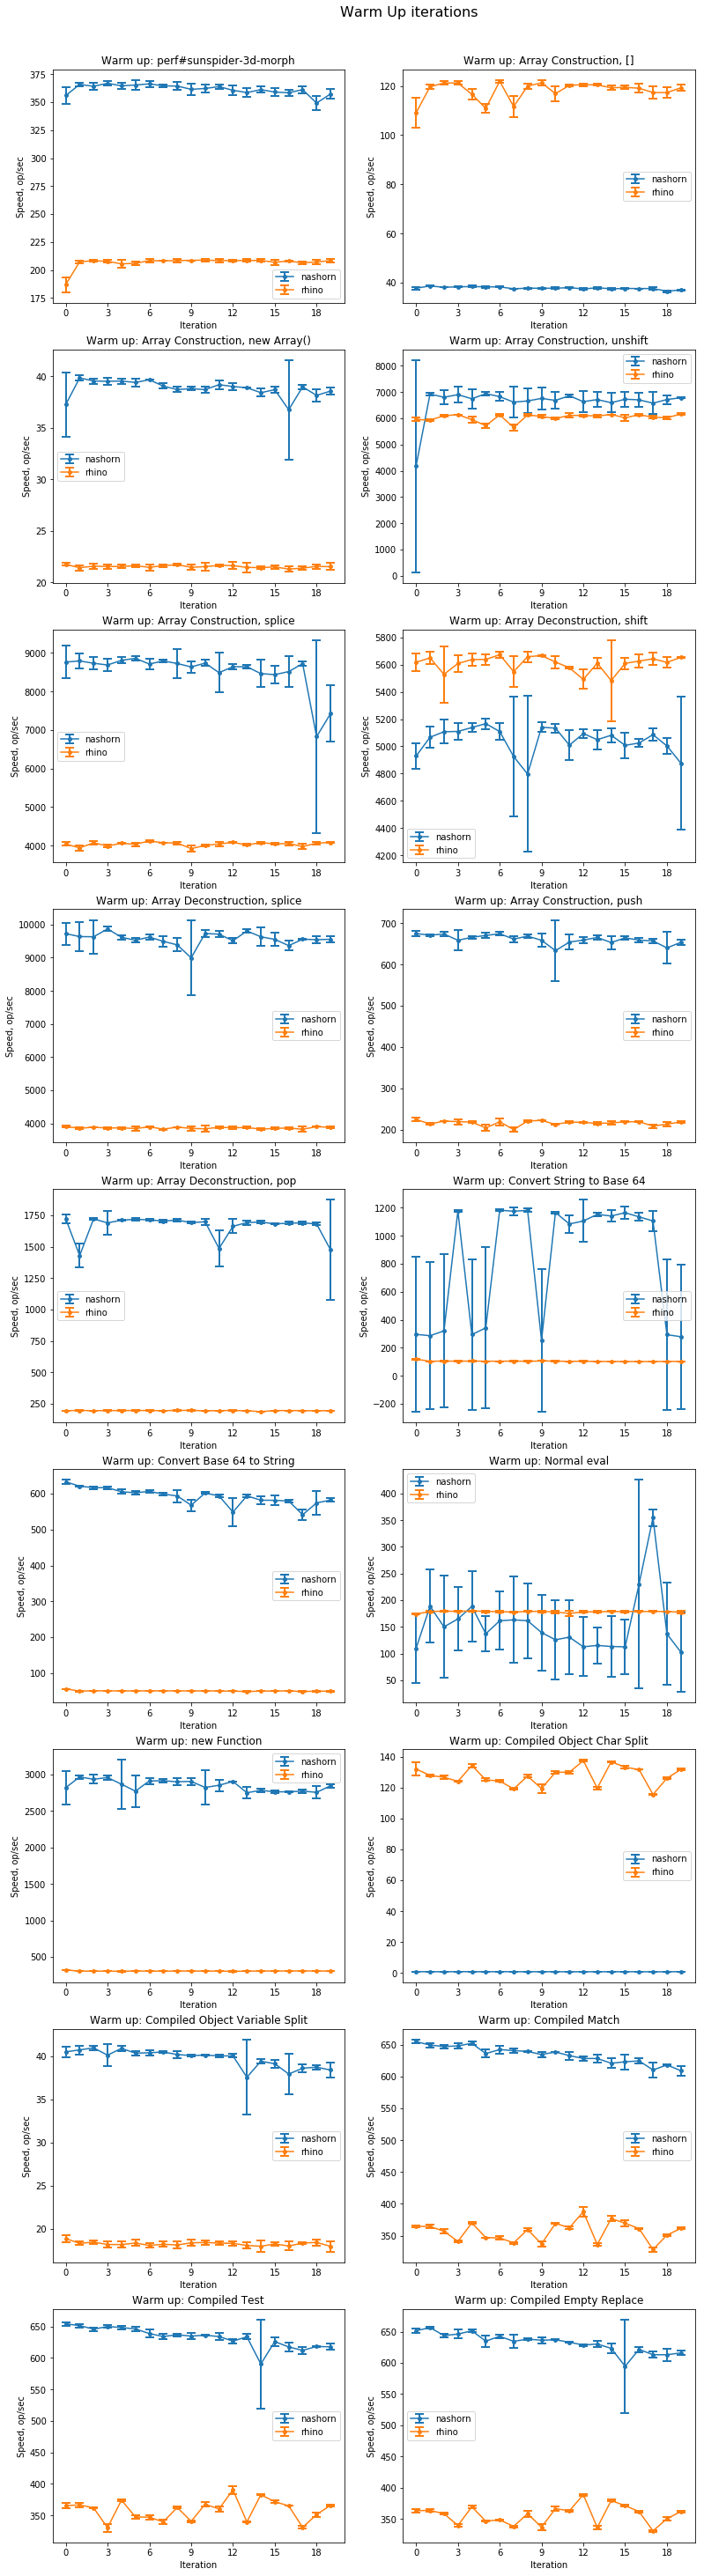

In [7]:
draw_warmup_tests()

In [8]:
def prepare_final_test():
    res = {}
    res['names'] = [test['name'] for test in data['nashorn'][0]]
    res['nashorn_values'] = [test['speed'] for test in data['nashorn'][0]]
    res['rhino_values'] = [test['speed'] for test in data['rhino'][0]]
    res['nashorn_over_rhino'] = \
        np.array(res['nashorn_values'])/ np.array(res['rhino_values']) 
    return res

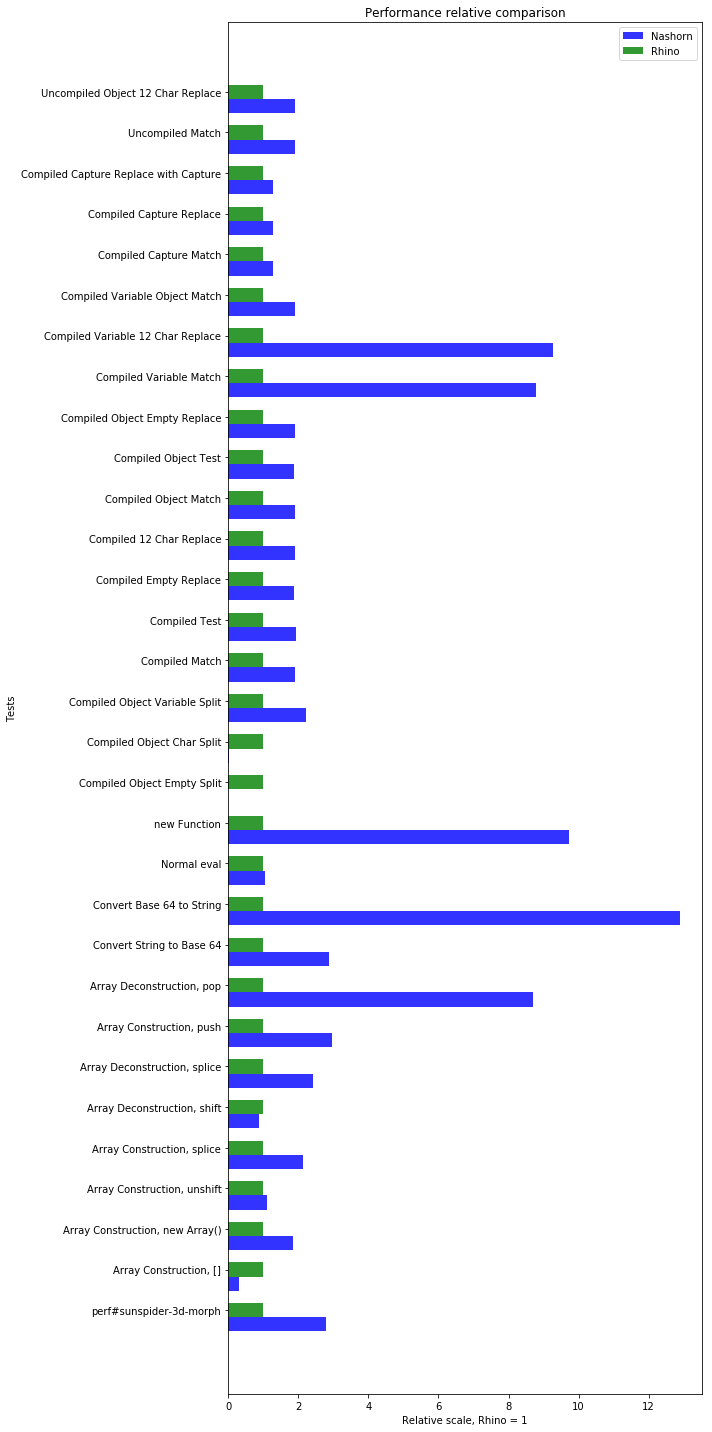

In [9]:
import numpy as np
import matplotlib.pyplot as plt
 
final_test_data = prepare_final_test()    
# data to plot
n_groups = len(final_test_data['names'])
nashorn_over_rhino_data = final_test_data['nashorn_over_rhino']
rhino_baseline = np.full((len(nashorn_over_rhino_data)),1)
 
# create plot
fig, ax = plt.subplots(figsize=(10,20))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.barh(index, nashorn_over_rhino_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Nashorn')
 
rects2 = plt.barh(index + bar_width, rhino_baseline, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Rhino')
 
plt.ylabel('Tests')
plt.xlabel('Relative scale, Rhino = 1')
plt.title('Performance relative comparison')
plt.yticks(index + bar_width, final_test_data['names'])
plt.legend()
 
plt.tight_layout()
plt.show()